In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import PCA

In [2]:
dataset_path = "D:/Buku_Tugas_Akhir/Training/traindivide/data_crop/"

In [3]:
def load_and_preprocess_images(data_dir):
    images = []
    labels = []
    label_map = {}
    for label_idx, label_name in enumerate(os.listdir(data_dir)):
        label_map[label_idx] = label_name
        label_path = os.path.join(data_dir, label_name)
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (50, 50))
            images.append(image)
            labels.append(label_idx)
    return np.array(images), np.array(labels), label_map

In [4]:
# Fungsi augmentasi gambar
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])

    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    # Add more augmentations here
    # Example:
    # imgs.append(cv2.flip(img, 0))  # Flip vertically
    # imgs.append(cv2.flip(img, 1))  # Flip horizontally

    return imgs

In [ ]:
# Fungsi augmentasi gambar
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    
    # Rotasi dengan berbagai derajat
    angles = [5, -5, 10, -10]
    translations = [3, -3, 6, -6]
    translations_y = [3, -3, 6, -6]
    brightness_adjustments = [10, 30, -10, -30, 15, 45, -15, -45]
    
    imgs = []
    
    # Augmentasi rotasi
    for angle in angles:
        M_rot = cv2.getRotationMatrix2D(center, angle, 1.0)
        imgs.append(cv2.warpAffine(img, M_rot, (w, h), borderValue=(255, 255, 255)))
    
    # Augmentasi translasi x
    for tx in translations:
        M_trans_x = np.float32([[1, 0, tx], [0, 1, 0]])
        imgs.append(cv2.warpAffine(img, M_trans_x, (w, h), borderValue=(255, 255, 255)))
    
    # Augmentasi translasi y
    for ty in translations_y:
        M_trans_y = np.float32([[1, 0, 0], [0, 1, ty]])
        imgs.append(cv2.warpAffine(img, M_trans_y, (w, h), borderValue=(255, 255, 255)))
    
    # Augmentasi kecerahan
    for adjustment in brightness_adjustments:
        imgs.append(cv2.add(img, adjustment))
    
    return imgs

In [5]:
# Load dan preprocess gambar
images, labels, label_map = load_and_preprocess_images(dataset_path)

In [6]:
# Menampilkan jumlah gambar sebelum augmentasi untuk masing-masing label
original_counts = {label: sum(1 for lbl in labels if lbl == label) for label in range(len(label_map))}
print("Jumlah gambar sebelum augmentasi:")
for label, count in original_counts.items():
    print(f"{label_map[label]}: {count}")

Jumlah gambar sebelum augmentasi:
Agung_Handayanto: 400
Andi_Agung: 400
Daniel_Rodearman: 400
David_Nababan: 400
Insan_Kamil: 400
Jona_Meivan: 400


In [7]:
# Menambahkan axis tambahan pada gambar asli
images = np.expand_dims(images, axis=-1)

In [8]:
# Augmentasi data
augmented_images = []
augmented_labels = []
for img, label in zip(images, labels):
    aug_images = img_augmentation(img.squeeze())
    aug_images = np.expand_dims(aug_images, axis=-1)
    augmented_images.extend(aug_images)
    augmented_labels.extend([label] * len(aug_images))

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [9]:
# Gabungkan gambar asli dengan gambar yang sudah di-augmentasi
final_images = np.concatenate([images, augmented_images])
final_labels = np.concatenate([labels, augmented_labels])

# Konversi label menjadi one-hot encoding
final_labels = to_categorical(final_labels, num_classes=len(label_map))

In [10]:
# Menampilkan jumlah gambar sesudah augmentasi untuk masing-masing label
augmented_counts = {label: sum(1 for lbl in augmented_labels if lbl == label) for label in range(len(label_map))}
print("\nJumlah gambar setelah augmentasi:")
for label, count in augmented_counts.items():
    print(f"{label_map[label]}: {count}")


Jumlah gambar setelah augmentasi:
Agung_Handayanto: 8000
Andi_Agung: 8000
Daniel_Rodearman: 8000
David_Nababan: 8000
Insan_Kamil: 8000
Jona_Meivan: 8000


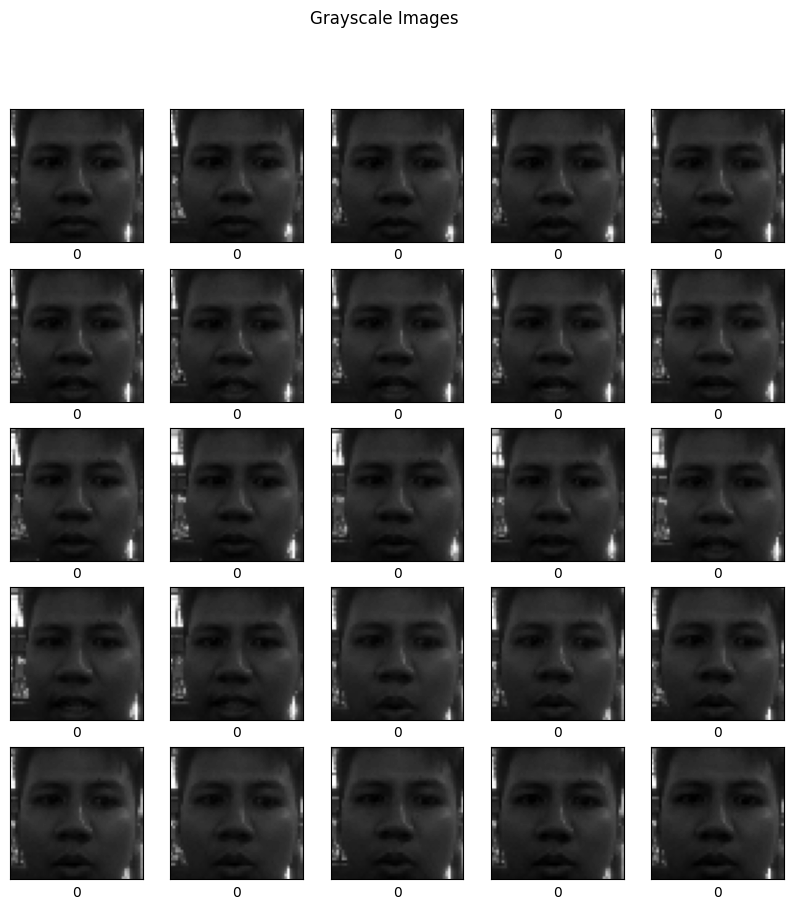

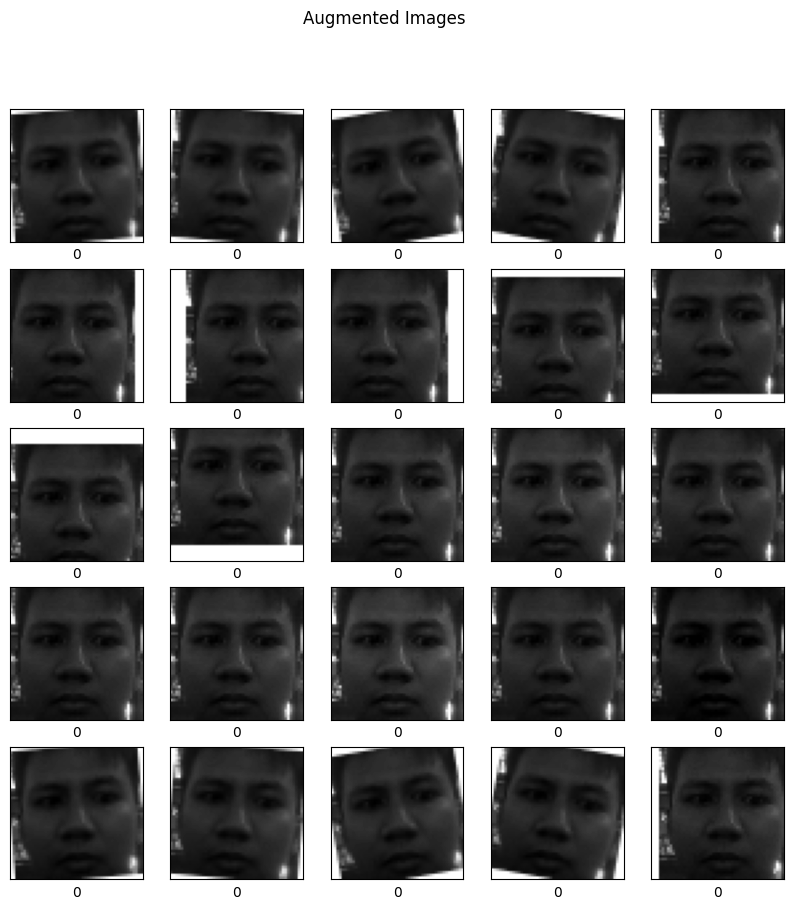

In [11]:
# Menampilkan beberapa gambar hasil preprocessing dan augmentasi
def display_samples(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.xlabel(labels[i])
    plt.suptitle(title)
    plt.show()

display_samples(images, labels[:len(images)], "Grayscale Images")
display_samples(augmented_images, augmented_labels[:len(augmented_images)], "Augmented Images")


In [13]:
# Membagi data menjadi training (70%) dan temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(final_images, final_labels, test_size=0.3, stratify=np.argmax(final_labels, axis=1), random_state=42)

# Membagi temporary set menjadi validation dan testing (50% dari temporary set masing-masing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

In [14]:
# Tampilkan jumlah sampel di setiap set
train_counts = {label: sum(1 for lbl in np.argmax(y_train, axis=1) if lbl == label) for label in range(len(label_map))}
val_counts = {label: sum(1 for lbl in np.argmax(y_val, axis=1) if lbl == label) for label in range(len(label_map))}
test_counts = {label: sum(1 for lbl in np.argmax(y_test, axis=1) if lbl == label) for label in range(len(label_map))}

print("\nJumlah sampel di setiap set:")
print("Training set:")
for label, count in train_counts.items():
    print(f"{label_map[label]}: {count}")
print("\nValidation set:")
for label, count in val_counts.items():
    print(f"{label_map[label]}: {count}")
print("\nTesting set:")
for label, count in test_counts.items():
    print(f"{label_map[label]}: {count}")


Jumlah sampel di setiap set:
Training set:
Agung_Handayanto: 5880
Andi_Agung: 5880
Daniel_Rodearman: 5880
David_Nababan: 5880
Insan_Kamil: 5880
Jona_Meivan: 5880

Validation set:
Agung_Handayanto: 1260
Andi_Agung: 1260
Daniel_Rodearman: 1260
David_Nababan: 1260
Insan_Kamil: 1260
Jona_Meivan: 1260

Testing set:
Agung_Handayanto: 1260
Andi_Agung: 1260
Daniel_Rodearman: 1260
David_Nababan: 1260
Insan_Kamil: 1260
Jona_Meivan: 1260


In [15]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
class auto_accuracy_stop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.96:
            print('\nAccuracy has reached 96%. Training stopped.')
            self.model.stop_training = True
auto_stop = auto_accuracy_stop()

In [16]:
# Membangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(50, 50, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])
# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

class auto_accuracy_stop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.96:
            print('\nAccuracy has reached 96%. Training stopped.')
            self.model.stop_training = True

auto_stop = auto_accuracy_stop()
# Melatih model
batch_size = 64
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint, auto_stop])

Epoch 1/50
1103/1103 [==============================] - ETA: 0s - loss: 4.1070 - accuracy: 0.4364
Epoch 1: val_accuracy improved from -inf to 0.79603, saving model to best_model.h5
1103/1103 [==============================] - 21s 12ms/step - loss: 4.1070 - accuracy: 0.4364 - val_loss: 1.8937 - val_accuracy: 0.7960
Epoch 2/50
1098/1103 [============================>.] - ETA: 0s - loss: 1.6821 - accuracy: 0.7613
Epoch 2: val_accuracy improved from 0.79603 to 0.91931, saving model to best_model.h5
1103/1103 [==============================] - 12s 11ms/step - loss: 1.6808 - accuracy: 0.7615 - val_loss: 1.0625 - val_accuracy: 0.9193
Epoch 3/50
1103/1103 [==============================] - ETA: 0s - loss: 1.0817 - accuracy: 0.8613
Epoch 3: val_accuracy improved from 0.91931 to 0.94775, saving model to best_model.h5
1103/1103 [==============================] - 12s 11ms/step - loss: 1.0817 - accuracy: 0.8613 - val_loss: 0.7729 - val_accuracy: 0.9478
Epoch 4/50
1100/1103 [========================

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)
report = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:")
print(report)

237/237 [==============================] - 3s 9ms/step
Confusion Matrix:
[[1248    1    0    1    6    4]
 [   0 1257    2    0    1    0]
 [   0    1 1217    9    3   30]
 [   1    1    6 1241    4    7]
 [   0    0    3    3 1254    0]
 [   0    0    8    1    6 1245]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1260
           1       1.00      1.00      1.00      1260
           2       0.98      0.97      0.98      1260
           3       0.99      0.98      0.99      1260
           4       0.98      1.00      0.99      1260
           5       0.97      0.99      0.98      1260

    accuracy                           0.99      7560
   macro avg       0.99      0.99      0.99      7560
weighted avg       0.99      0.99      0.99      7560



In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

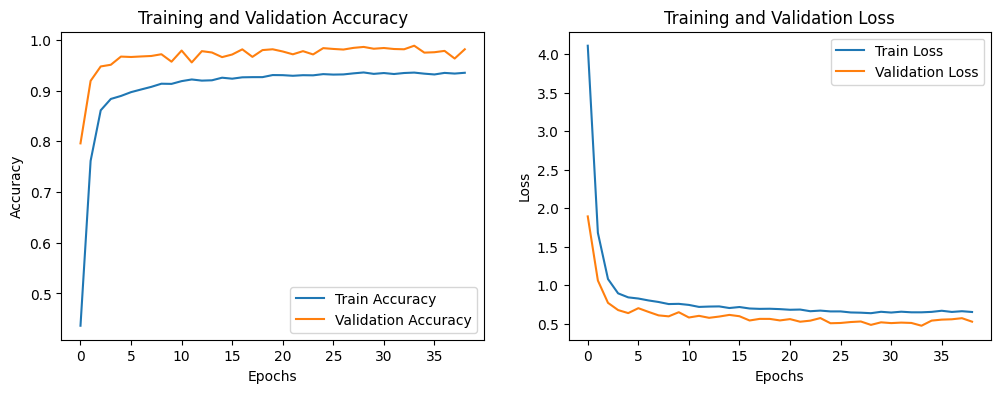

In [24]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [32]:
model.save('model.h5')

237/237 [==============================] - 1s 3ms/step


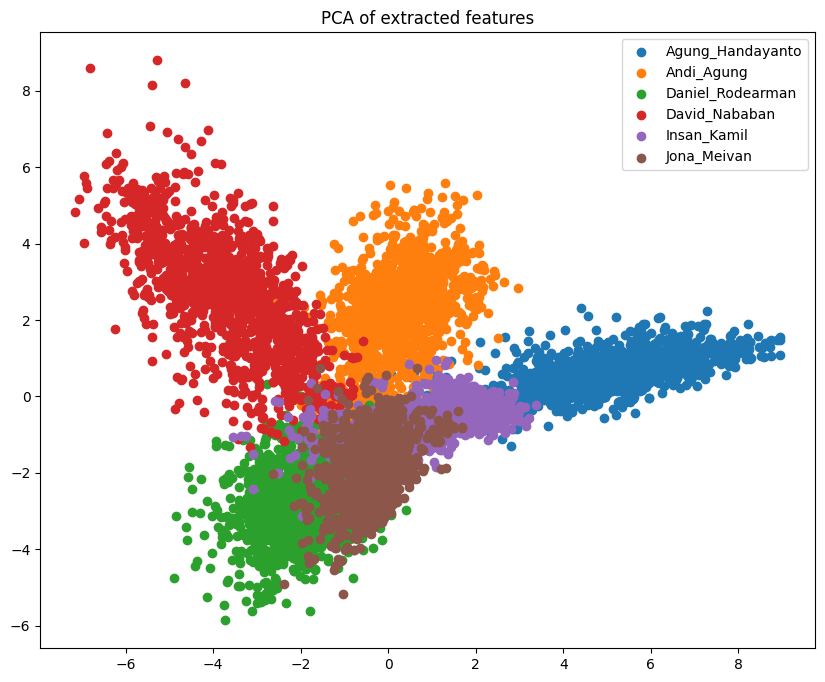

In [26]:
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
# Membuat model untuk ekstraksi fitur
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Ekstraksi fitur dari data validation
features = feature_extractor.predict(X_val)

# Visualisasi fitur dengan PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
for label in range(len(label_map)):
    indices = np.where(np.argmax(y_val, axis=1) == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label_map[label])
plt.legend()
plt.title('PCA of extracted features')
plt.show()

In [27]:
from sklearn.metrics import roc_curve, auc
# Menghitung ROC dan AUC untuk setiap label
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(label_map)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], model.predict(X_val)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

237/237 [==============================] - 1s 2ms/step


In [28]:
thresholds = {}
for i in range(len(label_map)):
    fpr, tpr, thresholds[i] = roc_curve(y_val[:, i], model.predict(X_val)[:, i])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[i][optimal_idx]
    print(f'Optimal threshold for {label_map[i]}: {optimal_threshold}')

237/237 [==============================] - 1s 3ms/step
Optimal threshold for Agung_Handayanto: 0.1882384568452835
237/237 [==============================] - 1s 3ms/step
Optimal threshold for Andi_Agung: 0.3279730975627899
237/237 [==============================] - 1s 2ms/step
Optimal threshold for Daniel_Rodearman: 0.24615754187107086
237/237 [==============================] - 1s 3ms/step
Optimal threshold for David_Nababan: 0.39987286925315857
237/237 [==============================] - 1s 2ms/step
Optimal threshold for Insan_Kamil: 0.27867239713668823
237/237 [==============================] - 1s 2ms/step
Optimal threshold for Jona_Meivan: 0.22476157546043396


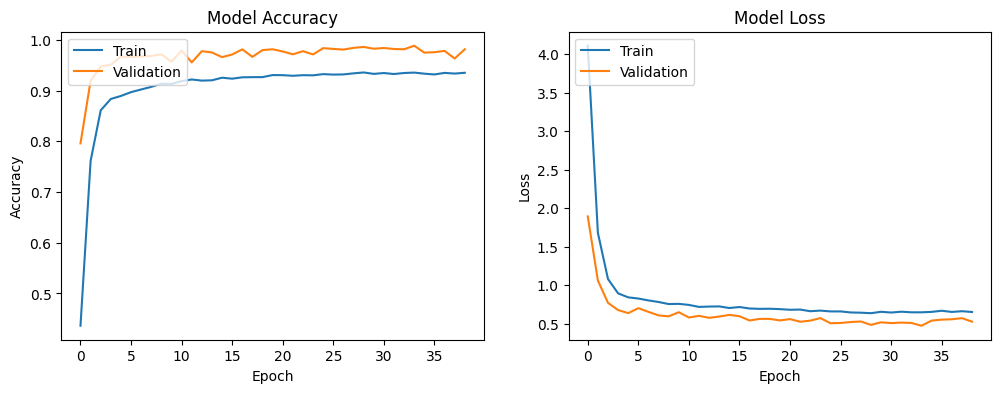

In [30]:
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Menampilkan kurva learning
plot_learning_curves(history)